# Capstone Project - Where is the best place to open a restaurant in Toronto?
### Project Report

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis, Results and Discussion](#analysis)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

Before opening a new restaurant in any place, it is essential to investigate the demand for it. It is crucial to investigate the criteria such as population density, availability of other restaurants (competition), income diversity of people around that area to identify whether opening a restaurant would be profitable. These features collectively enable identifying the hotspots for a restaurant that would generate the best income. In this project, we consider these aspects in identifying the best location in Toronto to open a restaurant by a certain client. 

**The business problem is identifying and recommending the client with a certain location/s in Toronto that would produce the best profit.** 

In order to achieve this task, we will investigate the population density, availability of other restaurants, and income diversity of the people in the Toronto neighborhoods. The population density will allow us identifying the densest areas that will roughly tell how frequently people will order food from a restaurant. For example, when a restaurant is located in a highly condensed area, the frequency of buying food from a certain restaurant is high. The availability of other restaurants will determine the competition. If a particular location has too many restaurants, it is not easy to attract many food buyers. While population density and competition play two significant roles, it is also essential to identify how affluent the area is. If the household income is lower in an area, buying food from restaurants might not be preferred. Based on these factors, we will use Foursquare API to explore neighborhoods in Toronto.

## Data <a name="data"></a>

For this project, we will first need neighborhood data of Toronto. Hence, we scrape neighborhood data from the Wikipedia page available at,
 https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050
Next, we wrangle the data and clean them to generate the following dataframe (Please note that it is only an abstract view of the entire dataset, and the original dataset has 103 records). The obtained dataset is composed of three columns: PostalCode, Borough, and Neighborhood. Note that we do not consider the records where the borough is "Not assigned". The records where one postal code having more than one neighborhood are merged into one record. Once the above dataframe is created, we merge the latitude and the longitude data of each location (each record) using the CSV file that has the geographical coordinates of each postal code available at https://github.com/courseraassignmentcapstone/Coursera_Capstone/blob/main/Geospatial_Coordinates.csv.
 Once the latitude and the longitude data are available, we can utilize Foursquare location data to further analyze the dynamics of the dataset to accomplish the necessary tasks of the project. An abstract view of the dataset with the latitude and longitude information is given below.

**Note:** In order to access Foursquare services, we need to have a valid developer account at https://foursquare.com/.

We obtain the data related to population density, availability of other restaurants (competition), income in Toronto from	 http://map.toronto.ca/wellbeing/#eyJ0b3Itd2lkZ2V0LWNsYXNzYnJlYWsiOsSAcGVyY2VudE9wYWNpdHnElzcwfSwiY3VzxIJtYcSTYcSXxIBuZWlnaGJvdXJob29kc8S2fcSrxIHEg8SFxIfEicSLdGFixYXEmCLEo3RpdmVUxZBJZMSXxYnEhMWPYi1pbmRpY2HEgnLFhcWIYWdzTWFwxLYiesWCbcSXMTPErHjEly04ODM3NzYzLjXGhDcyN8SsxKc6NTQxMjkzMS4yNMaDMjg1xYjFpMWmxajFqsWSxIDFmMWraW9uxJcyxKxzxaRnbGXFhsSsxZZtZXPEm2nGtsayxK3Ev8STxJ9JxaXFp8WpxINNxYPGsToixq1uxq%2FGscWH![image-6.png](attachment:image-6.png)

## Methodology <a name="methodology"></a>

In this section, we will discuss the steps used to identify the best location for a restaurant based on the data collected. 

We will first conduct a basic descriptive analysis of the datasets collected to get a brief idea of the dataset (collected from https://github.com/courseraassignmentcapstone/Coursera_Capstone/blob/main/toronto_data.csv) characteristics related to the project. 

This project aims to conduct a suitability analysis for a new restaurant to open in Toronto neighborhoods. We will limit our analysis to the top 100 venues that are in Toronto within a radius of ~8km. Next, we will run cluster analysis to identify the best place to open a restaurant. This analysis will plot the points and clusters in maps, generate bar plots, and conduct basic descriptive analysis to suggest the best neighborhoods to open a new restaurant. The stakeholders can then utilize this information to open a restaurant that produces a good income. 

### Extracting Toronto neibourhood data

Now let's look at the code for extracting Toronto neibourhood step by step.

First, we need to install and import relevant libraries. 

In [266]:
!pip install bs4
!pip install geocoder
!pip install folium

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

Now we use webscraping to extract data by retreiving the relevant URL from Wikipedia and create a Beautiful soup object. Next, we create a dataframe with the table data

In [267]:
postaldf = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]
postaldf = df[df.Borough!='Not assigned']
postaldf.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


Now read the csv file of coordinates available in a csv file that was previously uploaded to GitHub. 

In [268]:
geo_data = pd.read_csv("https://raw.githubusercontent.com/courseraassignmentcapstone/Coursera_Capstone/main/Geospatial_Coordinates.csv")
geo_data.rename(columns = {'Postal Code':'PostalCode'},inplace=True)
geo_data.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we download data from We obtain the data related to population density, availability of other restaurants (competition), income in Toronto from	 http://map.toronto.ca/wellbeing/#eyJ0b3Itd2lkZ2V0LWNsYXNzYnJlYWsiOsSAcGVyY2VudE9wYWNpdHnElzcwfSwiY3VzxIJtYcSTYcSXxIBuZWlnaGJvdXJob29kc8S2fcSrxIHEg8SFxIfEicSLdGFixYXEmCLEo3RpdmVUxZBJZMSXxYnEhMWPYi1pbmRpY2HEgnLFhcWIYWdzTWFwxLYiesWCbcSXMTPErHjEly04ODM3NzYzLjXGhDcyN8SsxKc6NTQxMjkzMS4yNMaDMjg1xYjFpMWmxajFqsWSxIDFmMWraW9uxJcyxKxzxaRnbGXFhsSsxZZtZXPEm2nGtsayxK3Ev8STxJ9JxaXFp8WpxINNxYPGsToixq1uxq%2FGscWH

Please note that we consider the **2008** dataset as the data of the recent years provide more sparseness. **We also make another assumption that the total number of businesses provides a reflection of the number of restaurants in a given neighborhood.** By considering this assumption, we rename the **"Businesses"** column to **"Competition"**.

**Note:** We also consider the Pre-Tax Household Income as the Household Income, and we rename the corresponding column to "Income". 

The downloaded data are then uploaded to GitHub and available at https://github.com/courseraassignmentcapstone/Coursera_Capstone/blob/main/toronto_data.csv

Let's read the data from this link

In [269]:
toronto_data = pd.read_csv("https://raw.githubusercontent.com/courseraassignmentcapstone/Coursera_Capstone/main/toronto_data.csv")
toronto_data.rename(columns={'Businesses': 'Competition'}, inplace=True)
toronto_data.rename(columns={'Total Population': 'Population'}, inplace=True)
toronto_data.rename(columns={'Pre-Tax Household Income': 'Income'}, inplace=True)
toronto_data.head()

,Neighbourhood,Competition,Population,Income
0,West Humber-Clairville,2550,32265,63415
1,Mount Olive-Silverstone-Jamestown,273,32130,48145
2,Thistletown-Beaumond Heights,236,9925,55030
3,Rexdale-Kipling,155,10725,52430
4,Elms-Old Rexdale,70,9440,53780


Now, we add the latitude and longitude information to the above dataset

In [270]:
newdf = pd.merge(postaldf, geo_data, left_on='Postcode', right_on='PostalCode').drop(['PostalCode', 'Postcode', 'Borough'], axis=1)
maindata = pd.merge(newdf, toronto_data, on='Neighbourhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
maindata.head()

,Neighbourhood,Latitude,Longitude,Competition,Population,Income
0,Victoria Village,43.725882,-79.315572,398.0,17050.0,42315.0
1,Rouge,43.806686,-79.194353,832.0,43180.0,76945.0
2,Malvern,43.806686,-79.194353,665.0,44315.0,56610.0
3,Highland Creek,43.784535,-79.160497,91.0,12845.0,86850.0
4,Flemingdon Park,43.725900,-79.340923,220.0,21290.0,41280.0


### Connecting to Foursquare to retrieve data related to restaurants in the neighbourhoods

In this step, we use Foursquare API to get info on the restaurants in each neighbourhood. We restrict the analysis to 
the top 100 venues in Toronto within a radius of 8km.

In [313]:

CLIENT_ID = 'NAZOIHKAZYBVYPI0WKVNV03YZJOB5QOTAHR2HJSUZPB215FJ' # Foursquare ID
CLIENT_SECRET = 'DFWNCR44Y0YX54BDMKUJA5MUJHRKCWZCK1WX5QIE1DIMOVSG' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(names, latitudes, longitudes, radius=8000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

toronto_venues = getNearbyVenues(names=maindata['Neighbourhood'],
                                   latitudes=maindata['Latitude'],
                                   longitudes=maindata['Longitude']
                                  )
toronto_venues.head()

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
1,Victoria Village,43.725882,-79.315572,Naan & Kabob Halal,43.742903,-79.305148,Middle Eastern Restaurant
2,Victoria Village,43.725882,-79.315572,Toronto Climbing Academy,43.709362,-79.315006,Rock Climbing Spot
3,Victoria Village,43.725882,-79.315572,Adonis,43.729188,-79.290391,Grocery Store
4,Victoria Village,43.725882,-79.315572,Ghadir Mid-Eastern Grocery,43.743638,-79.304233,Grocery Store


## Analysis, Results and Discussion <a name="analysis"></a>

In this section, we will run the analysis and generate results for the different experiments. The results are then discussed accordingly. 

Let's first evaluate the competition of the neighborhoods by plotting a barplot on the "Competition" data.

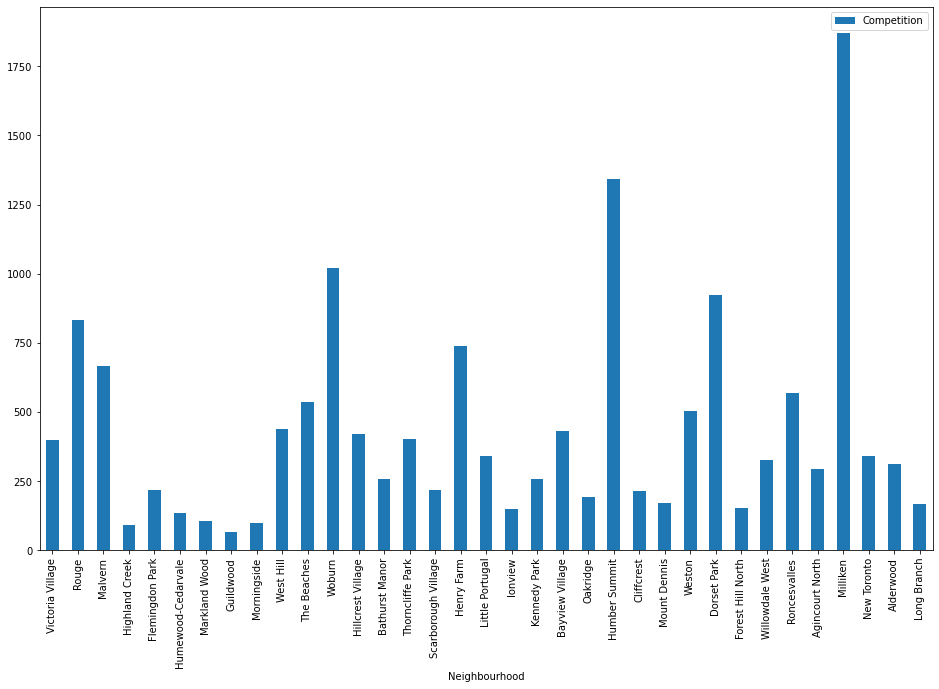

In [293]:
import matplotlib.pyplot as plt
import pandas as pd

ax = plt.gca()
maindata.plot(kind='bar',x='Neighbourhood',y='Competition',ax=ax, figsize=(16, 10))
plt.show()


Let's check the record that contain the highest competition,

In [294]:
maindata.loc[maindata['Competition'].idxmax()]

Neighbourhood    Milliken
Latitude          43.8153
Longitude        -79.2846
Competition          1871
Population          26265
Income              60350
Name: 31, dtype: object

Milliken shows the highest competition for a new business as shown in the bar chart and the above record. This suggests that it is challenging to open a new business in this area.

Let's evaluate the population statistics of the neighborhoods by plotting a barplot on the "Population" data. 

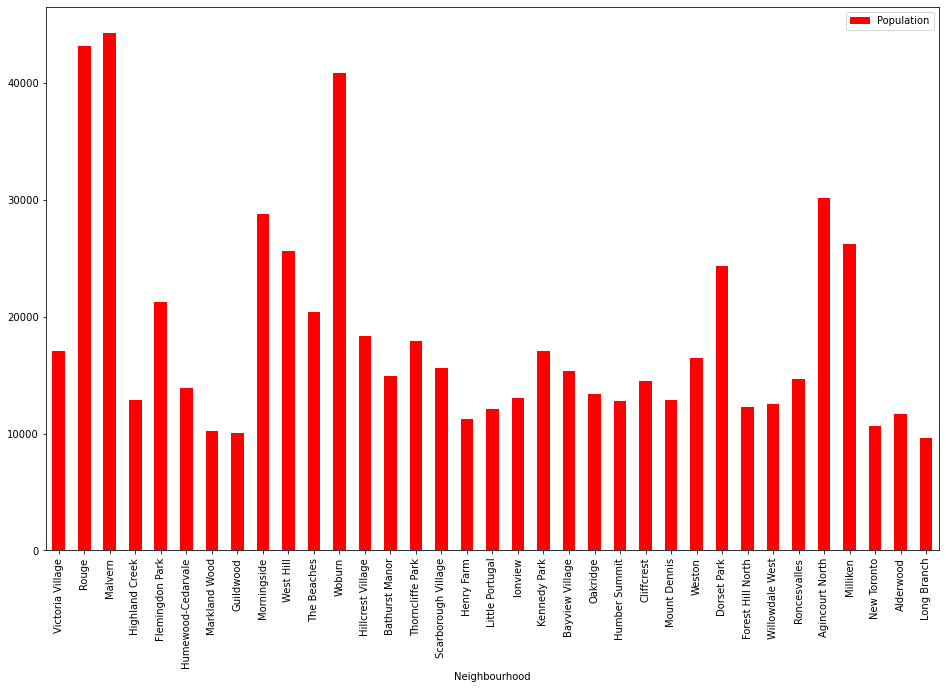

In [295]:
ax = plt.gca()
maindata.plot(kind='bar',x='Neighbourhood',y='Population', color = 'red', ax=ax, figsize=(16, 10))
plt.show()

Let's check the record that contain the highest Population,

In [296]:
maindata.loc[maindata['Population'].idxmax()]

Neighbourhood    Malvern
Latitude         43.8067
Longitude       -79.1944
Competition          665
Population         44315
Income             56610
Name: 2, dtype: object

Malvern has the highest population. This means that a restaurant in Malvern may attract many customers.

Let's evaluate the income statistics of the neighborhoods by plotting a barplot on the "Income" data.

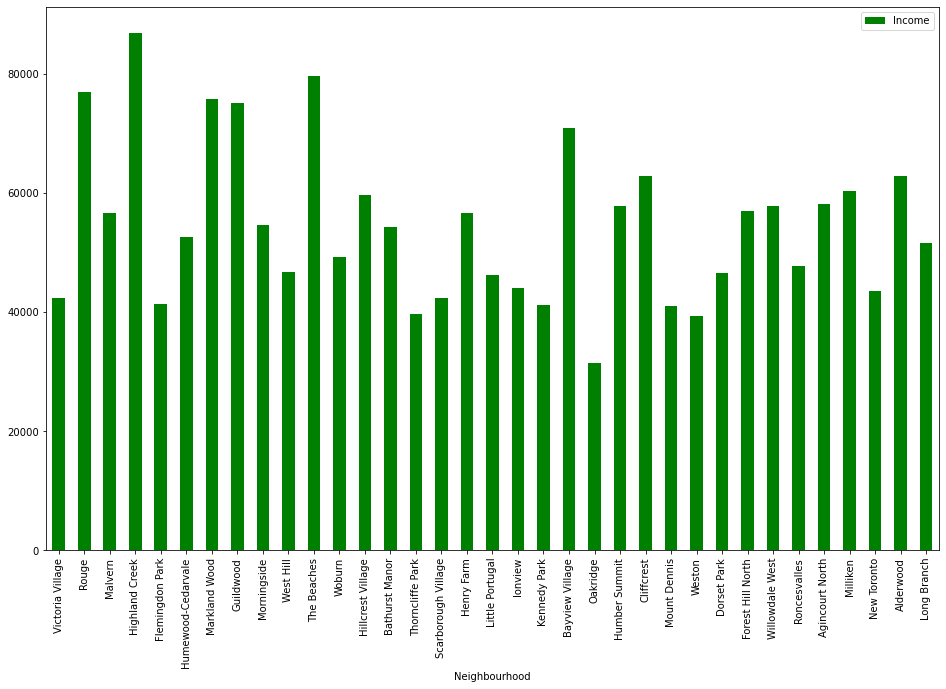

In [297]:
ax = plt.gca()
maindata.plot(kind='bar',x='Neighbourhood',y='Income', color = 'green', ax=ax, figsize=(16, 10))
plt.show()

Let's check the record that contain the highest Income,

In [298]:
maindata.loc[maindata['Income'].idxmax()]

Neighbourhood    Highland Creek
Latitude                43.7845
Longitude              -79.1605
Competition                  91
Population                12845
Income                    86850
Name: 3, dtype: object

As shown in the bar graph and the above record, Highland Creek is the area with the highest income. This may have an impact on people to buy from restaurants regularly.

#### Let's plot the data in a map using the Folium API

In [299]:
latitude = maindata['Latitude']
longitude = maindata['Longitude']

import folium
torontomap = folium.Map(location=[latitude[0], longitude[0]], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(maindata['Latitude'], maindata['Longitude'],  maindata['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(torontomap)  
    
torontomap

Let's get the top 100 venues that are in Toronto within a radius of 8000 meters

### Analyzing the neighbourhoods

In [300]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo Exhibit,African Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [301]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo Exhibit,African Restaurant,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,Agincourt North,0.073684,0.00,0.00,0.000000,0.000000,0.010526,0.021053,0.010526,0.00,...,0.00,0.00,0.00,0.010526,0.00,0.000000,0.00,0.010526,0.00,0.00
1,Alderwood,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.00,0.00,0.00,0.020000,0.02,0.000000,0.01,0.000000,0.01,0.00
2,Bathurst Manor,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,...,0.00,0.00,0.00,0.010000,0.01,0.000000,0.00,0.000000,0.00,0.00
3,Bayview Village,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,...,0.00,0.00,0.01,0.010000,0.00,0.000000,0.00,0.000000,0.00,0.00
4,Cliffcrest,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.010000,0.000000,0.00,...,0.00,0.01,0.02,0.010000,0.01,0.000000,0.00,0.010000,0.00,0.00
5,Dorset Park,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.020000,0.010000,0.00,...,0.00,0.01,0.00,0.010000,0.01,0.000000,0.00,0.010000,0.00,0.00
6,Flemingdon Park,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.010000,0.000000,0.00,...,0.00,0.02,0.00,0.010000,0.01,0.000000,0.00,0.000000,0.00,0.00
7,Forest Hill North,0.000000,0.00,0.00,0.000000,0.010000,0.010000,0.010000,0.000000,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00
8,Guildwood,0.070000,0.00,0.00,0.000000,0.000000,0.010000,0.020000,0.010000,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.010000,0.00,0.02
9,Henry Farm,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.010000,0.000000,0.00,...,0.00,0.00,0.00,0.020000,0.00,0.000000,0.00,0.000000,0.00,0.00


Putting the data into a pandas dataframe

In [302]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Zoo Exhibit,Caribbean Restaurant,Coffee Shop,Supermarket,Bakery,Grocery Store,Restaurant,Burger Joint,Bubble Tea Shop,Chinese Restaurant
1,Alderwood,Park,Bakery,Coffee Shop,Café,Seafood Restaurant,Burger Joint,Grocery Store,Breakfast Spot,Ice Cream Shop,Burrito Place
2,Bathurst Manor,Coffee Shop,Café,Park,Grocery Store,Italian Restaurant,Korean Restaurant,Japanese Restaurant,Supermarket,Middle Eastern Restaurant,Bakery
3,Bayview Village,Coffee Shop,Supermarket,Middle Eastern Restaurant,Bakery,Café,Caribbean Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Park
4,Cliffcrest,Park,Middle Eastern Restaurant,Coffee Shop,Beach,Burger Joint,Bakery,Breakfast Spot,Pub,Indian Restaurant,Grocery Store


#### Clustering neighborhoods
Let's run k-means to cluster the neighborhood into 5 clusters.

In [303]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 4, 4, 3, 0, 3, 2, 0, 4], dtype=int32)

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [304]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = maindata

# merge toronto_merged with toronto_df to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,Competition,Population,Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Victoria Village,43.725882,-79.315572,398.0,17050.0,42315.0,3,Park,Café,Grocery Store,Bakery,Beach,Brewery,Sandwich Place,Coffee Shop,Pizza Place,Greek Restaurant
1,Rouge,43.806686,-79.194353,832.0,43180.0,76945.0,0,Zoo Exhibit,Park,Indian Restaurant,Caribbean Restaurant,Coffee Shop,Pub,Hakka Restaurant,Supermarket,Burger Joint,Breakfast Spot
2,Malvern,43.806686,-79.194353,665.0,44315.0,56610.0,0,Zoo Exhibit,Park,Indian Restaurant,Caribbean Restaurant,Coffee Shop,Pub,Hakka Restaurant,Supermarket,Burger Joint,Breakfast Spot
3,Highland Creek,43.784535,-79.160497,91.0,12845.0,86850.0,0,Zoo Exhibit,Park,Ice Cream Shop,Breakfast Spot,Coffee Shop,Pub,Pharmacy,Mexican Restaurant,Indian Restaurant,Restaurant
4,Flemingdon Park,43.725900,-79.340923,220.0,21290.0,41280.0,3,Park,Café,Bakery,Grocery Store,Middle Eastern Restaurant,Supermarket,Italian Restaurant,Coffee Shop,Brewery,Turkish Restaurant


#### Plotting the data on a map

In [305]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude[0], longitude[0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examinig Clusters

##### Cluster 1

In [306]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Latitude,Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,43.806686,76945.0,0,Zoo Exhibit,Park,Indian Restaurant,Caribbean Restaurant,Coffee Shop,Pub,Hakka Restaurant,Supermarket,Burger Joint,Breakfast Spot
2,43.806686,56610.0,0,Zoo Exhibit,Park,Indian Restaurant,Caribbean Restaurant,Coffee Shop,Pub,Hakka Restaurant,Supermarket,Burger Joint,Breakfast Spot
3,43.784535,86850.0,0,Zoo Exhibit,Park,Ice Cream Shop,Breakfast Spot,Coffee Shop,Pub,Pharmacy,Mexican Restaurant,Indian Restaurant,Restaurant
7,43.763573,75025.0,0,Park,Zoo Exhibit,Coffee Shop,Caribbean Restaurant,Pharmacy,Japanese Restaurant,Indian Restaurant,Grocery Store,Restaurant,Pub
8,43.763573,54590.0,0,Park,Zoo Exhibit,Coffee Shop,Caribbean Restaurant,Pharmacy,Japanese Restaurant,Indian Restaurant,Grocery Store,Restaurant,Pub
9,43.763573,46740.0,0,Park,Zoo Exhibit,Coffee Shop,Caribbean Restaurant,Pharmacy,Japanese Restaurant,Indian Restaurant,Grocery Store,Restaurant,Pub
11,43.770992,49305.0,0,Caribbean Restaurant,Park,Indian Restaurant,Zoo Exhibit,Coffee Shop,Burger Joint,Middle Eastern Restaurant,Liquor Store,Italian Restaurant,Sandwich Place
15,43.744734,42415.0,0,Park,Caribbean Restaurant,Middle Eastern Restaurant,Indian Restaurant,Coffee Shop,Burger Joint,Restaurant,Grocery Store,Beach,Bookstore
26,43.757410,46485.0,0,Caribbean Restaurant,Park,Coffee Shop,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Burger Joint,Grocery Store,Sandwich Place
30,43.815252,58095.0,0,Zoo Exhibit,Caribbean Restaurant,Coffee Shop,Supermarket,Bakery,Grocery Store,Restaurant,Burger Joint,Bubble Tea Shop,Chinese Restaurant


#### Examinig Clusters

##### Cluster 2

In [307]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Latitude,Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,43.643515,75700.0,1,Burrito Place,Grocery Store,Burger Joint,Bakery,Coffee Shop,Restaurant,Brewery,Seafood Restaurant,Hotel,Sandwich Place
22,43.756303,57810.0,1,Steakhouse,Coffee Shop,Italian Restaurant,Hotel,Sporting Goods Shop,Bakery,Ice Cream Shop,Asian Restaurant,Gym,Burger Joint
25,43.706876,39300.0,1,Coffee Shop,Italian Restaurant,Café,Liquor Store,Brewery,Bar,Bakery,Asian Restaurant,Grocery Store,Park
33,43.602414,62840.0,1,Park,Bakery,Coffee Shop,Café,Seafood Restaurant,Burger Joint,Grocery Store,Breakfast Spot,Ice Cream Shop,Burrito Place
34,43.602414,51505.0,1,Park,Bakery,Coffee Shop,Café,Seafood Restaurant,Burger Joint,Grocery Store,Breakfast Spot,Ice Cream Shop,Burrito Place


#### Examinig Clusters

##### Cluster 3

In [308]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Latitude,Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,43.693781,52590.0,2,Café,Park,Coffee Shop,Bakery,Pizza Place,Grocery Store,Bar,Furniture / Home Store,French Restaurant,Liquor Store
14,43.705369,39580.0,2,Park,Coffee Shop,Café,Brewery,Italian Restaurant,Bakery,Concert Hall,Ice Cream Shop,BBQ Joint,Grocery Store
17,43.647927,46195.0,2,Park,Café,Coffee Shop,Bakery,Sandwich Place,Pizza Place,Bar,Dessert Shop,Farmers Market,Plaza
24,43.691116,41060.0,2,Park,Café,Bakery,Coffee Shop,Pizza Place,Sandwich Place,Bar,Ice Cream Shop,Liquor Store,Dog Run
27,43.696948,56970.0,2,Café,Park,Coffee Shop,Bakery,Brewery,Japanese Restaurant,Grocery Store,Pizza Place,French Restaurant,Sandwich Place
29,43.648960,47685.0,2,Park,Café,Bakery,Coffee Shop,Ice Cream Shop,Pizza Place,Italian Restaurant,Indian Restaurant,Sandwich Place,Scenic Lookout


#### Examinig Clusters

##### Cluster 4

In [309]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Latitude,Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,43.725882,42315.0,3,Park,Café,Grocery Store,Bakery,Beach,Brewery,Sandwich Place,Coffee Shop,Pizza Place,Greek Restaurant
4,43.725900,41280.0,3,Park,Café,Bakery,Grocery Store,Middle Eastern Restaurant,Supermarket,Italian Restaurant,Coffee Shop,Brewery,Turkish Restaurant
10,43.676357,79665.0,3,Coffee Shop,Park,Grocery Store,Beach,Farmers Market,Brewery,Historic Site,Liquor Store,Bakery,Other Great Outdoors
18,43.727929,44090.0,3,Park,Coffee Shop,Beach,Burger Joint,Caribbean Restaurant,Bakery,Middle Eastern Restaurant,Grocery Store,Café,Burrito Place
19,43.727929,41130.0,3,Park,Coffee Shop,Beach,Burger Joint,Caribbean Restaurant,Bakery,Middle Eastern Restaurant,Grocery Store,Café,Burrito Place
21,43.711112,31365.0,3,Park,Beach,Coffee Shop,Brewery,Bakery,Middle Eastern Restaurant,Café,BBQ Joint,Pizza Place,Sandwich Place
23,43.716316,62770.0,3,Park,Middle Eastern Restaurant,Coffee Shop,Beach,Burger Joint,Bakery,Breakfast Spot,Pub,Indian Restaurant,Grocery Store
32,43.605647,43440.0,3,Park,Coffee Shop,Café,Bakery,Ice Cream Shop,Italian Restaurant,Seafood Restaurant,Scenic Lookout,Restaurant,Burger Joint


#### Examinig Clusters

##### Cluster 5

In [310]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Latitude,Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,43.803762,59610.0,4,Chinese Restaurant,Bakery,Japanese Restaurant,Caribbean Restaurant,Hotel,Supermarket,Middle Eastern Restaurant,Greek Restaurant,Bubble Tea Shop,Coffee Shop
13,43.754328,54315.0,4,Coffee Shop,Café,Park,Grocery Store,Italian Restaurant,Korean Restaurant,Japanese Restaurant,Supermarket,Middle Eastern Restaurant,Bakery
16,43.778517,56645.0,4,Supermarket,Bakery,Caribbean Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Grocery Store,Shopping Mall,Japanese Restaurant,Coffee Shop,Fish Market
20,43.786947,70855.0,4,Coffee Shop,Supermarket,Middle Eastern Restaurant,Bakery,Café,Caribbean Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Park
28,43.782736,57735.0,4,Coffee Shop,Café,Middle Eastern Restaurant,Grocery Store,Supermarket,Bagel Shop,Park,Liquor Store,Korean Restaurant,Furniture / Home Store


Let's investigate how the income varies in each cluster using line plots for each cluster

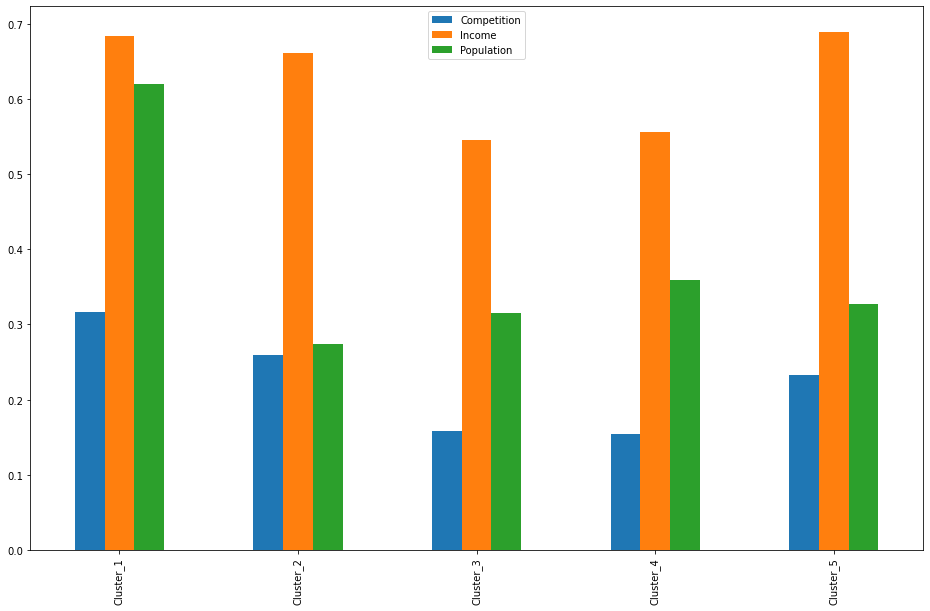

In [312]:
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
cluster_3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]
cluster_4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]
cluster_5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

maxincome = max(toronto_merged['Income'])

#Normalized mean income of each cluster
cluster_1_income_mean = cluster_1['Income'].mean()/maxincome
cluster_2_income_mean = cluster_2['Income'].mean()/maxincome
cluster_3_income_mean = cluster_3['Income'].mean()/maxincome
cluster_4_income_mean = cluster_4['Income'].mean()/maxincome
cluster_5_income_mean = cluster_5['Income'].mean()/maxincome

incomedata = [cluster_1_income_mean, cluster_2_income_mean,cluster_3_income_mean,cluster_4_income_mean,cluster_5_income_mean]

maxpopulation = max(toronto_merged['Population'])

#Normalized mean population of each cluster
cluster_1_population_mean = cluster_1['Population'].mean()/maxpopulation
cluster_2_population_mean = cluster_2['Population'].mean()/maxpopulation
cluster_3_population_mean = cluster_3['Population'].mean()/maxpopulation
cluster_4_population_mean = cluster_4['Population'].mean()/maxpopulation
cluster_5_population_mean = cluster_5['Population'].mean()/maxpopulation

populationdata = [cluster_1_population_mean,cluster_2_population_mean,cluster_3_population_mean,cluster_4_population_mean,cluster_5_population_mean]

maxcompetition = max(toronto_merged['Competition'])

#Normalized mean income of each cluster
cluster_1_competition_mean = cluster_1['Competition'].mean()/maxcompetition
cluster_2_competition_mean = cluster_2['Competition'].mean()/maxcompetition
cluster_3_competition_mean = cluster_3['Competition'].mean()/maxcompetition
cluster_4_competition_mean = cluster_4['Competition'].mean()/maxcompetition
cluster_5_competition_mean = cluster_5['Competition'].mean()/maxcompetition

competitiondata = [cluster_1_competition_mean,cluster_2_competition_mean,cluster_3_competition_mean,cluster_4_competition_mean,cluster_5_competition_mean]


clustdata_df = pd.DataFrame([competitiondata,incomedata,populationdata], index=['Competition','Income','Population'],
                    columns=['Cluster_1','Cluster_2','Cluster_3','Cluster_4','Cluster_5'])

transposedf = clustdata_df.transpose()

ax = plt.gca()
transposedf.plot(kind='bar', ax=ax, figsize=(16, 10))
plt.show()

In this section, we discuss the results.  According to our analysis, the first cluster (numbered as cluster 0 on the map) provides the best place to start a new restaurant. According to the bar chart, it can be seen that there is a high population and income although the competition is a little bit high. However, the competition compared to other clusters is not drastically high in the first cluster. As it is visible, the competition is close to that of clusters 2 and 5. Hence, we suggest that the area around the Malvern (Malvern cluster 0 as depicted in the map) is the best place to open a restaurant. 

## Conclusion <a name="conclusion"></a>

In this project, we tried to identify a suitable place for a new restaurant based on three factors; competition, population, and income. We first extracted data on these statistics, and then we merged the geographical data to the corresponding data to conduct geographical analysis based on clustering. In our analysis, we showed the dynamics of different places in Toronto. Then we also suggested a certain area that shows the best performance in terms of competition, population, and income. However, the final decision to open a restaurant in a certain place will be taken by the stakeholders. The stakeholders can effectively use the insights produced in the project to take this decision effectively.